In [1]:
# import modules
"""
Created on Tue Feb 20 15:10:00 2018

@author: Yacalis
"""

import os
import json
import numpy as np
from Callbacks import Callbacks
from Config import Config
from dataLoader import retrieve_data
from folder_defs import get_log_dir, get_data_dir, get_train_dir, get_test_dir
from train_model import train_model
from build_model import build_model
from save_model import save_model
from get_data_dict import get_data_dict

/Users/Yacalis/.virtualenvs/cs/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print('Beginning program')

Beginning program


In [3]:
# get config
config = Config().config
print('change lr:', config.change_lr)
print('change bs:', config.change_bs)
print('max epochs:', config.epochs)
if config.change_bs == config.change_lr:
    print(f'[!] Whoops: config.change_bs and config.change_lr should be '
          f'different bool values, but they are both {config.change_bs} '
          f'-- please set one and only one of them to True')

unparsed config options: ['-f', '/Users/Yacalis/Library/Jupyter/runtime/kernel-5819be23-c311-4c76-9879-38513f48aeef.json']
change lr: True
change bs: False
max epochs: 20


In [4]:
#config.change_lr = False
#config.change_bs = True

In [5]:
# get directories
log_dir = get_log_dir(config)
data_dir = get_data_dir()
train_dir = get_train_dir()
test_dir = get_test_dir()
print('log dir:', log_dir)
print('data dir:', data_dir)
print('train dir:', train_dir)
print('test dir:', test_dir)

log dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/logs/0308_1837-clr-bs_4-v_complex
data dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/
train dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/test_images/train/
test dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/test_images/test/


In [6]:
# get data
print('Loading data...')
data_dict = get_data_dict(data_dir)

Loading data...
data file:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/imdb.mat
number of records from data file:  460723


In [7]:
x_data, y_data = retrieve_data(data_dict=data_dict, image_dir=test_dir)

image dir:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/test_images/test/
	sub dirs:
		 00
		 01
		 02
		 03
		 04
		 05
shape of x_data:  (295, 228, 228, 3)


In [10]:
y_data.sum(axis=0)

array([128, 167])

In [20]:
x = 128/(128+167) * 100
x

43.389830508474574

In [19]:
print(f"female: {int(x)}, male: {int(100 - x)}")

female: 43, male: 56


In [6]:
x_data, y_data = retrieve_data(data_dict=data_dict, image_dir=train_dir)
num_train = int(x_data.shape[0] * 0.8)
print(f'Num training examples (excludes test and val): {num_train}')

Loading data...
data file:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/imdb.mat
number of records from data file:  460723
image dir:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/test_images/train/
	sub dirs:
		 00
		 01
		 02
		 03
		 04
		 05
shape of x_data:  (4229, 228, 228, 3)
Num training examples (excludes test and val): 3383


In [6]:
# build and save initial model
input_dim = x_data[0].shape
model = build_model(input_dim, config, model_type=config.complexity)
save_model(log_dir=log_dir, config=config, model=model)

Building model...
Finished building model
Compiling model...
Finished compiling
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 256)       1024      
______________________________________________________________

In [7]:
# set variables
val_loss = []
val_acc = []
loss = []
acc = []
lr = []
bs = []
max_epochs = config.epochs
batch_size = config.batch_size
batch_size_mult = 2
epoch_iter = 1

In [8]:
# get callbacks
callbacks = Callbacks(config, log_dir).callbacks
print('callbacks:')
for callback in callbacks:
    print('\t', callback)

callbacks:


In [ ]:
# train model
if config.change_lr:  # reduce_lr callback takes care of everything for us
    print('Will reduce learning rate during training, but not batch size')
    print('Training model...')
    model, history = train_model(model, x_data, y_data, batch_size, max_epochs, callbacks)

    # store history (bs is constant)
    val_loss += history.history['val_loss']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    acc += history.history['acc']
    lr += history.history['lr']
    bs = [batch_size for i in range(len(lr))]

elif config.change_bs:  # need to manually stop and restart training
    print('Will reduce batch size during training, but not learning rate')
    while max_epochs >= epoch_iter:
        print(f'Currently at epoch {epoch_iter} of {max_epochs}, batch size is {batch_size}')
        epochs = max_epochs - epoch_iter + 1
        model, history = train_model(model, x_data, y_data, batch_size, epochs, callbacks)

        # store history
        val_loss += history.history['val_loss']
        val_acc += history.history['val_acc']
        loss += history.history['loss']
        acc += history.history['acc']
        bs += [batch_size for i in range(len(history.epoch))]

        # update training parameters
        epoch_iter += len(history.epoch)
        batch_size *= batch_size_mult
        batch_size = batch_size if batch_size < num_train else num_train

    # store lr history as constant
    lr = [0.001 for i in range(len(bs))]

else:  # this should never happen
    print(f'[!] Whoops: config.change_bs and config.change_lr are both '
          f'set to False - please set one of them to True')

print('Completed training')

Will reduce learning rate during training, but not batch size
Training model...
Train on 3383 samples, validate on 846 samples
Epoch 1/20
1412/3383 [===========>..................] - ETA: 3:25 - loss: 6.8910 - acc: 0.5659

In [10]:
# save finished model
save_model(log_dir=log_dir, config=config, model=model)

Saving model...
Model saved


In [11]:
# save loss, accuracy, lr, and bs values across epochs as json
acc_loss_lr_bs = {'val_loss': val_loss,
                  'val_acc': val_acc,
                  'loss': loss,
                  'acc': acc,
                  'lr': [np.float64(i) for i in lr],
                  'bs': bs
                  }
acc_loss_lr_bs_path = os.path.join(log_dir, 'acc_loss_lr_bs.json')
with open(acc_loss_lr_bs_path, 'w') as f:
    json.dump(acc_loss_lr_bs, f, indent=4, sort_keys=True)

In [12]:
# evaluate model
print('Calculating final score...')
x_data, y_data = retrieve_data(data_dict=data_dict, image_dir=test_dir)
score = model.evaluate(x_data, y_data, batch_size=batch_size)
print('Final score:', score)

Calculating final score...
image dir:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/test_images/val/
	sub dirs:
		 00
		 01
		 02
		 03
		 04
		 05
shape of x_data:  (295, 228, 228, 3)
295/295 [==============================] - 8s 27ms/step
Final score: [6.9554936000224155, 0.5661016951173039]


In [13]:
print('Completed program')

Completed program


In [14]:
# PLOTTING FOR TESTING
import matplotlib.pyplot as plt

In [15]:
# load dict from json
d = None
with open(acc_loss_lr_bs_path, 'r') as f:
    d = json.load(f)

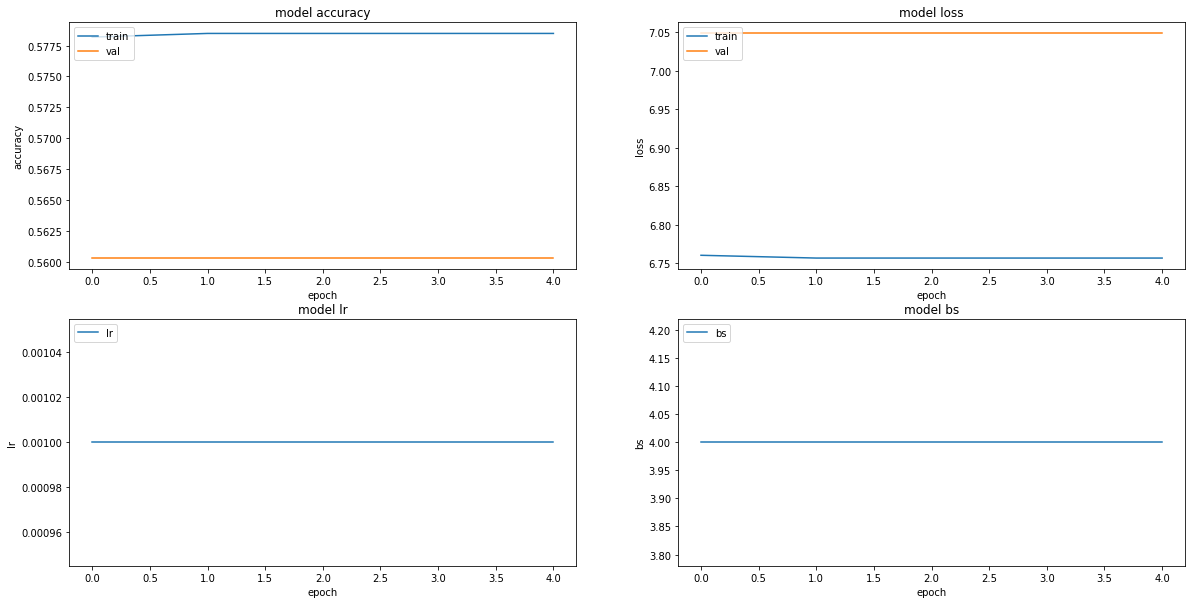

In [16]:
# plot dict values
plt.figure(figsize=(20,10))

# summarize history for accuracy
plt.subplot(2, 2, 1)
plt.plot(d['acc'])
plt.plot(d['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(2, 2, 2)
plt.plot(d['loss'])
plt.plot(d['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for lr
plt.subplot(2, 2, 3)
plt.plot(d['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.legend(['lr'], loc='upper left')

# summarize history for bs
plt.subplot(2, 2, 4)
plt.plot(d['bs'])
plt.title('model bs')
plt.ylabel('bs')
plt.xlabel('epoch')
plt.legend(['bs'], loc='upper left')

plt.show()

In [1]:
from get_data_dict import get_new_data_dict
from dataLoader import retrieve_data
from folder_defs import get_data_dir, get_train_dir, get_test_dir

In [2]:
data_dir = get_data_dir()
train_dir = get_train_dir()
test_dir = get_test_dir()
print(data_dir, train_dir, test_dir, sep='\n')

/Users/Yacalis/Projects/TensorFlow/cs274c-data/
/Users/Yacalis/Projects/TensorFlow/cs274c-project/test_images/new_train/
/Users/Yacalis/Projects/TensorFlow/cs274c-project/test_images/new_test/


In [3]:
data_dict = get_new_data_dict(data_dir)

data file:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/new_testing_data.csv
number of records from data file:  648


In [4]:
data_dict

{'00/nm0000100_rm1002674432_1955-1-6_2003.jpg': 1,
 '00/nm0000100_rm1019451648_1955-1-6_2003.jpg': 1,
 '00/nm0000100_rm1129814016_1955-1-6_2007.jpg': 1,
 '00/nm0000100_rm1247254528_1955-1-6_2007.jpg': 1,
 '00/nm0000100_rm230922496_1955-1-6_2003.jpg': 1,
 '00/nm0000100_rm3003101696_1955-1-6_2011.jpg': 1,
 '00/nm0000100_rm341607680_1955-1-6_1994.jpg': 1,
 '00/nm0000100_rm3822295296_1955-1-6_2003.jpg': 1,
 '00/nm0000100_rm862094592_1955-1-6_2011.jpg': 1,
 '00/nm0000100_rm984792064_1955-1-6_2011.jpg': 1,
 '00/nm0000200_rm1060673536_1955-5-17_2006.jpg': 1,
 '00/nm0000200_rm1308089088_1955-5-17_2013.jpg': 1,
 '00/nm0000200_rm1309194496_1955-5-17_1995.jpg': 1,
 '00/nm0000200_rm1359714304_1955-5-17_2004.jpg': 1,
 '00/nm0000200_rm1472103680_1955-5-17_2006.jpg': 0,
 '00/nm0000200_rm1754635008_1955-5-17_2003.jpg': 1,
 '00/nm0000200_rm206805504_1955-5-17_1996.jpg': 1,
 '00/nm0000200_rm2186910208_1955-5-17_2000.jpg': 1,
 '00/nm0000200_rm2315622912_1955-5-17_2005.jpg': 1,
 '00/nm0000200_rm2556136960